Parse Text Data, make Train Split
---

In [1]:
import glob
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, vstack
import numpy as np
from sklearn.preprocessing import normalize

def parse_lyrics():
    unique_line_ratios = []
    artists = []
    titles = []
    genres = []
    lyric_strings = []
    total_word_counts = []
    average_word_counts_per_line = []
    
    #iterate through files
    for filename in glob.iglob('data/*.txt'):
        genre = filename[5:len(filename)-4]
        numberOfSongs = 0
        file = open(filename)
        lines = file.readlines()
        i = 0
        while i < len(lines) and not lines[i].startswith("###"):
            i = i + 1
        while i < len(lines):
            numberOfSongs = numberOfSongs + 1
            artists.append(lines[i][3:].strip())
            titles.append(lines[i+1][3:].strip())
            genres.append(genre) 
            i = i + 2
            #extract features from song
            
            lyrics = []
            while i < len(lines) and not lines[i].startswith("###"):
                line = lines[i].strip()                
                if line != "":
                    lyrics.append(line)
                i = i + 1
                
            lyric_string = make_lyric_string(lyrics)
            lyric_strings.append(lyric_string)
            unique_line_ratios.append(calc_unique_line_ratio(lyrics))
            total_word_counts.append(count_words(lyric_string))
               
    
    return unique_line_ratios, artists, titles, genres, lyric_strings, total_word_counts, average_word_counts_per_line;

def calc_unique_line_ratio(lyrics):
    return len(set(lyrics)) / len(lyrics)

def make_lyric_string(lyric_lines):
    lyric_string = ''
    for l in lyric_lines:
        lyric_string += l+' '
    return lyric_string 

def count_words(lyric_string):
    return len(lyric_string.split())

##Parse The Data
unique_line_ratios, artists, titles, genres, raw_lyrics, total_word_counts, average_word_counts_per_line = parse_lyrics()
##Prepare "Dumb" Features
data_bow = TfidfVectorizer().fit_transform(raw_lyrics).toarray()
##Make More intelligent Features
data_feature = TfidfVectorizer().fit_transform(raw_lyrics).toarray()
data_feature = np.append(data_feature, np.swapaxes(np.asarray([unique_line_ratios]),0,1), 1)
data_feature = np.append(data_feature, np.swapaxes(np.asarray(normalize(total_word_counts)),0,1), 1)

X_train_feature, X_test_feature, X_train_bow, X_test_bow, y_train, y_test = train_test_split(data_feature, data_bow, genres, test_size=0.33, random_state=42)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Classify
---

In [2]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

cls = OneVsRestClassifier(LinearSVC(random_state=0))

cls.fit(X_train_bow, y_train)
pred_bow = cls.predict(X_test_bow)

cls.fit(X_train_feature, y_train)
pred_feature = cls.predict(X_test_feature)

Evaluate
---

### BOW Classifier ###



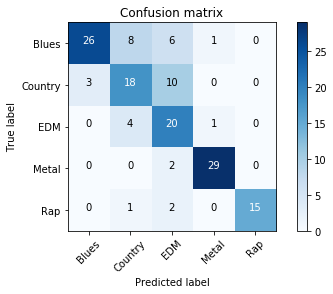

F1 micro: 0.739726027397
F1 macro: 0.756692339918


### Feature Classifier ###



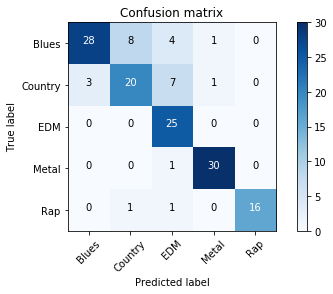

F1 micro: 0.815068493151
F1 macro: 0.826330532213


In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
print("### BOW Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_bow), ["Blues","Country", "EDM", "Metal", "Rap"])
print ("F1 micro: " + str(f1_score(pred_bow, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_bow, y_test, average='macro')))

print("\n\n### Feature Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_feature), ["Blues","Country", "EDM", "Metal", "Rap"])
print ("F1 micro: " + str(f1_score(pred_feature, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_feature, y_test, average='macro')))